In [1]:
import pandas as pd

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [2]:
with open("../data/rnaseq/gm12878_read_count.txt", "r") as f:
    f.readline()
    gm12878_counts_df = pd.read_csv(f, index_col=0, sep="\t")


with open("../data/rnaseq/h1esc_read_count.txt", "r") as f:
    f.readline()
    h1esc_counts_df = pd.read_csv(f, index_col=0, sep="\t")

with open("../data/rnaseq/hffc6_read_count.txt", "r") as f:
    f.readline()
    hffc6_counts_df = pd.read_csv(f, index_col=0, sep="\t")

In [3]:
gm12878_counts_df

,Chr,Start,End,Strand,Length,ENCFF800HIP.filtered.bam,ENCFF991KKX.filtered.bam
Geneid,,,,,,,
ENSG00000223972.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,11869;12010;12179;12613;12613;12975;13221;1322...,12227;12057;12227;12721;12697;13052;13374;1440...,+;+;+;+;+;+;+;+;+,1735,0,0
ENSG00000227232.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351,0,0
ENSG00000278267.1,chr1,17369,17436,-,68,1,3
ENSG00000243485.5,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31109;31097,+;+;+;+;+,1021,0,0
ENSG00000284332.1,chr1,30366,30503,+,138,0,0
...,...,...,...,...,...,...,...
ENSG00000198695.2,chrM,14149,14673,-,525,1754,1990
ENSG00000210194.1,chrM,14674,14742,-,69,29,32
ENSG00000198727.2,chrM,14747,15887,+,1141,49459,44474


In [4]:
gm12878_counts_df = gm12878_counts_df[['ENCFF800HIP.filtered.bam', 'ENCFF991KKX.filtered.bam']].T
h1esc_counts_df = h1esc_counts_df[['ENCFF675NTU.filtered.bam', 'ENCFF379NOY.filtered.bam']].T
hffc6_counts_df = hffc6_counts_df[['ENCFF307KUI.filtered.bam', 'ENCFF294BSI.filtered.bam', 'ENCFF937TEI.filtered.bam']].T

In [5]:
def compute_deseq_stats_for_2_celllines(cellline1_counts_df, cellline2_counts_df, cellline1_name="CellLine1", cellline2_name="CellLine2"):
    cl1_vs_cl2_counts_df = pd.concat(
        [cellline1_counts_df, cellline2_counts_df]
    )

    cl1_vs_cl2_metadata_df = pd.DataFrame(
        {
            "condition": [cellline1_name] * cellline1_counts_df.shape[0] + [cellline2_name] * cellline2_counts_df.shape[0]
        },
        index=cl1_vs_cl2_counts_df.index,
    )

    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=cl1_vs_cl2_counts_df,
        metadata=cl1_vs_cl2_metadata_df,
        design="~condition",
        refit_cooks=True,
        inference=inference,
    )

    dds.deseq2()
    stats = DeseqStats(dds, contrast=["condition", cellline1_name, cellline2_name])
    stats.summary()

    results_df = stats.results_df.dropna()
    results_df['symbol'] = results_df.index
    return results_df

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

def plot_deseq_volcano(
    deseq_results,
    log2fc_threshold=1,
    padj_threshold=0.05,
    figsize=(12, 10),
    up_color="red",
    down_color="blue",
    non_sig_color="gray",
    point_size=25,
    point_alpha=0.7,
    title="Volcano Plot",
    plot_path=None,
    font_size=24
):
    plt.figure(figsize=figsize)

    results_df = deseq_results.copy()

    results_df["-log10(padj)"] = -np.log10(results_df["padj"].clip(lower=1e-300))

    def get_color(row):
        if row["padj"] < padj_threshold:
            if row["log2FoldChange"] > log2fc_threshold:
                return up_color
            elif row["log2FoldChange"] < -log2fc_threshold:
                return down_color
        return non_sig_color

    results_df["color"] = results_df.apply(get_color, axis=1)

    sns.scatterplot(
        data=results_df,
        x="log2FoldChange",
        y="-log10(padj)",
        hue="color",
        palette={up_color: up_color, down_color: down_color, non_sig_color: non_sig_color},
        alpha=point_alpha,
        s=point_size,
        legend=False
    )

    plt.axvline(x=log2fc_threshold, color="black", linestyle="--", alpha=0.5)
    plt.axvline(x=-log2fc_threshold, color="black", linestyle="--", alpha=0.5)
    plt.axhline(y=-np.log10(padj_threshold), color="black", linestyle="--", alpha=0.5)

    plt.title(title, fontsize=font_size)
    plt.xlabel("log2 Fold Change", fontsize=font_size)
    plt.ylabel("-log10 adjusted p-value", fontsize=font_size)

    sig_up = len(results_df[(results_df["padj"] < padj_threshold) & (results_df["log2FoldChange"] > log2fc_threshold)])
    sig_down = len(results_df[(results_df["padj"] < padj_threshold) & (results_df["log2FoldChange"] < -log2fc_threshold)])
    non_sig = len(results_df) - sig_up - sig_down

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=up_color, markersize=10,
               label=f'Up-expressed'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=down_color, markersize=10,
               label=f'Down-expressed'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=non_sig_color, markersize=10,
               label=f'Not significant')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=font_size)

    if plot_path:
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    else:
        plt.tight_layout()
    return plt

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.21 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.42 seconds.

Fitting LFCs...
... done in 1.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.34 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_13537/365144667.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res

Log2 fold change & Wald test p-value: condition GM12878 vs H1ESC
                       baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                                
ENSG00000223972.5      0.000000             NaN       NaN       NaN   
ENSG00000227232.5      0.000000             NaN       NaN       NaN   
ENSG00000278267.1      2.248036       -0.506469  1.823320 -0.277773   
ENSG00000243485.5      0.000000             NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN   
...                         ...             ...       ...       ...   
ENSG00000198695.2   2048.736260       -0.437514  0.086208 -5.075096   
ENSG00000210194.1     23.651924        0.576258  0.577638  0.997612   
ENSG00000198727.2  38697.120986        0.371529  0.058147  6.389494   
ENSG00000210195.2     89.769900        1.306326  0.306061  4.268188   
ENSG00000210196.2     98.976794        0.069780  0.282614  0.246908   

           

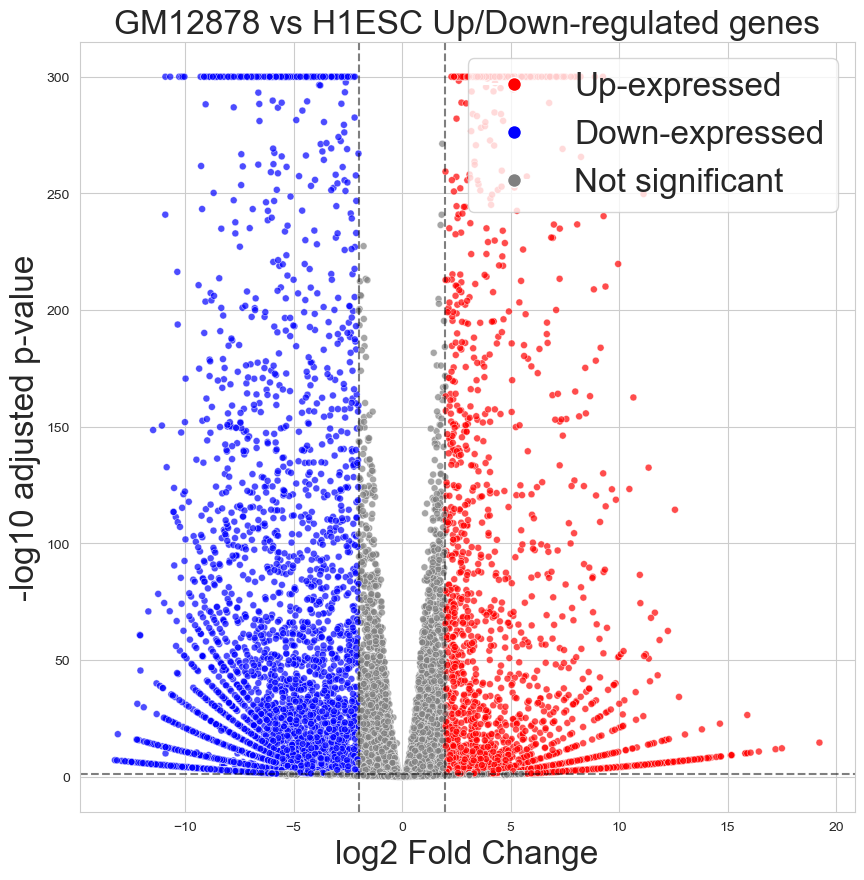

In [27]:
gm12878_vs_h1esc_results_df = compute_deseq_stats_for_2_celllines(
    gm12878_counts_df,
    h1esc_counts_df,
    cellline1_name="GM12878",
    cellline2_name="H1ESC"
)

print("Down", len(gm12878_vs_h1esc_results_df[gm12878_vs_h1esc_results_df['log2FoldChange'] > 2]))
print("Up", len(gm12878_vs_h1esc_results_df[gm12878_vs_h1esc_results_df['log2FoldChange'] < -2]))
print("Stays", len(gm12878_vs_h1esc_results_df[(gm12878_vs_h1esc_results_df['log2FoldChange'] < 2) & (gm12878_vs_h1esc_results_df['log2FoldChange'] > -2)]))

plt = plot_deseq_volcano(
    gm12878_vs_h1esc_results_df,
    log2fc_threshold=2,
    padj_threshold=0.05,
    figsize=(10, 10),
    up_color="red",
    down_color="blue",
    non_sig_color="gray",
    point_size=25,
    point_alpha=0.7,
    title="GM12878 vs H1ESC Up/Down-regulated genes",
    plot_path="figs/exp4_gm_h1_volcano.png"
)

# plt.show()

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.15 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.60 seconds.

Fitting LFCs...
... done in 1.16 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.53 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_13537/365144667.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res

Log2 fold change & Wald test p-value: condition H1ESC vs HFFC6
                       baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                                
ENSG00000223972.5      0.000000             NaN       NaN       NaN   
ENSG00000227232.5      4.548690       -5.383865  2.586318 -2.081671   
ENSG00000278267.1      1.372396        1.891656  2.006040  0.942980   
ENSG00000243485.5      0.000000             NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN   
...                         ...             ...       ...       ...   
ENSG00000198695.2   1669.869168        0.718368  0.150894  4.760729   
ENSG00000210194.1     12.167266        1.037633  0.679102  1.527948   
ENSG00000198727.2  25784.760948        0.497953  0.193864  2.568560   
ENSG00000210195.2    106.491115       -1.604338  0.280161 -5.726478   
ENSG00000210196.2     64.532522        0.902914  0.328352  2.749838   

             

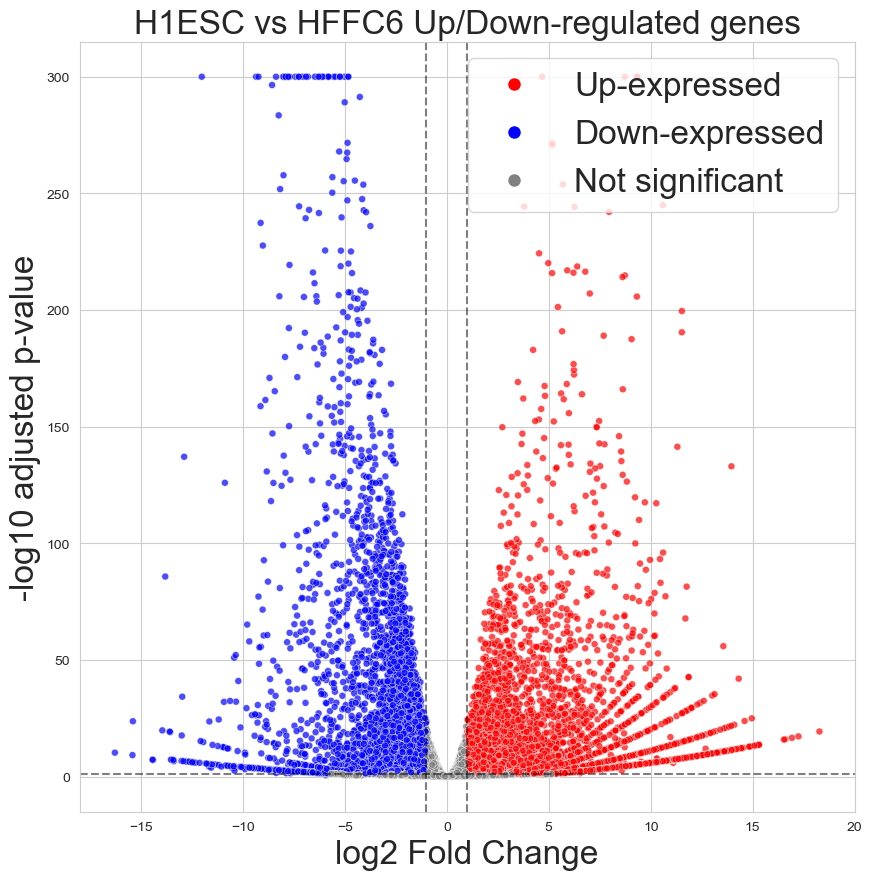

In [28]:
h1esc_vs_hffc6_results_df = compute_deseq_stats_for_2_celllines(
    h1esc_counts_df,
    hffc6_counts_df,
    cellline1_name="H1ESC",
    cellline2_name="HFFC6"
)

print("Down", len(h1esc_vs_hffc6_results_df[h1esc_vs_hffc6_results_df['log2FoldChange'] > 1]))
print("Up", len(h1esc_vs_hffc6_results_df[h1esc_vs_hffc6_results_df['log2FoldChange'] < -1]))
print("Stays", len(h1esc_vs_hffc6_results_df[(h1esc_vs_hffc6_results_df['log2FoldChange'] < 1) & (h1esc_vs_hffc6_results_df['log2FoldChange'] > -1)]))

plt = plot_deseq_volcano(
    h1esc_vs_hffc6_results_df,
    log2fc_threshold=1,
    padj_threshold=0.05,
    figsize=(10, 10),
    up_color="red",
    down_color="blue",
    non_sig_color="gray",
    point_size=25,
    point_alpha=0.7,
    title="H1ESC vs HFFC6 Up/Down-regulated genes",
    plot_path="figs/exp4_h1_hffc_volcano.png"
)

# plt.show()

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.31 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

/opt/anaconda3/envs/enhancer3D/lib/python3.13/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.83 seconds.

Fitting LFCs...
... done in 1.22 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.33 seconds.

/var/folders/ss/9hx8q7517rzf6x75cfny7ndc0000gp/T/ipykernel_13537/365144667.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res

Log2 fold change & Wald test p-value: condition HFFC6 vs GM12878
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                          
ENSG00000223972.5      0.000000             NaN       NaN       NaN       NaN   
ENSG00000227232.5      4.876008        5.631698  2.581318  2.181715  0.029131   
ENSG00000278267.1      1.138906       -1.341493  2.194531 -0.611289  0.541008   
ENSG00000243485.5      0.000000             NaN       NaN       NaN       NaN   
ENSG00000284332.1      0.000000             NaN       NaN       NaN       NaN   
...                         ...             ...       ...       ...       ...   
ENSG00000198695.2   1520.630326       -0.231177  0.157710 -1.465835  0.142693   
ENSG00000210194.1     16.391290       -1.564962  0.603404 -2.593556  0.009499   
ENSG00000198727.2  30956.220844       -0.819239  0.191453 -4.279060  0.000019   
ENSG00000210195.2    142.558092        0.348

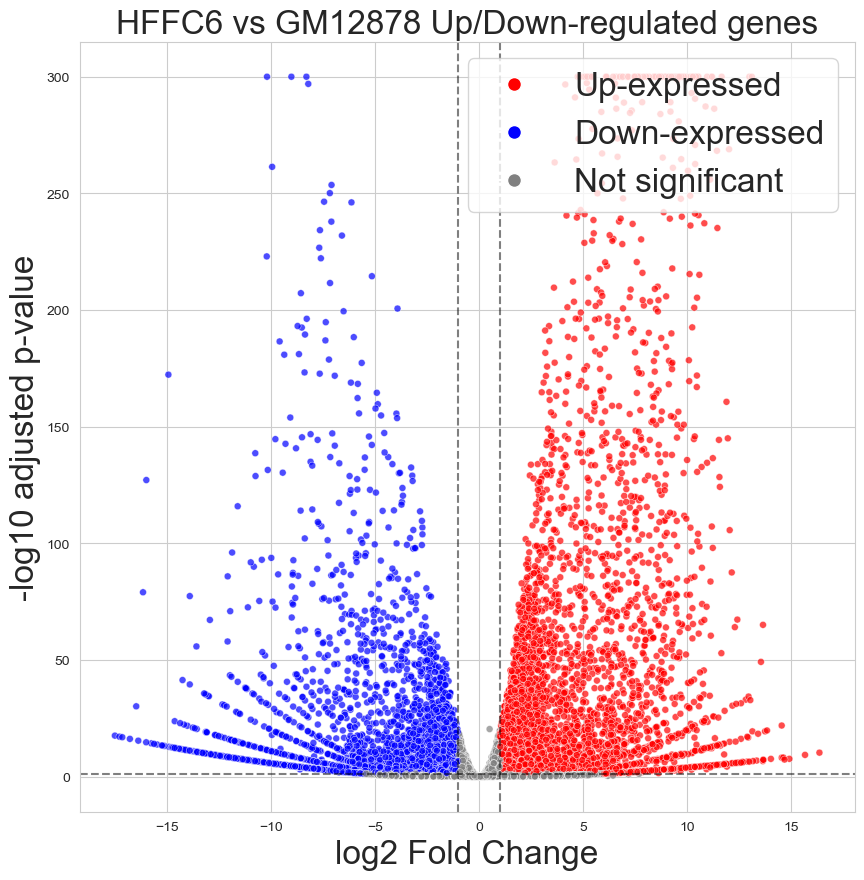

In [29]:
hffc6_vs_gm12878_results_df = compute_deseq_stats_for_2_celllines(
    hffc6_counts_df,
    gm12878_counts_df,
    cellline1_name="HFFC6",
    cellline2_name="GM12878"
)

print("Down", len(hffc6_vs_gm12878_results_df[hffc6_vs_gm12878_results_df['log2FoldChange'] > 1]))
print("Up", len(hffc6_vs_gm12878_results_df[hffc6_vs_gm12878_results_df['log2FoldChange'] < -1]))
print("Stays", len(hffc6_vs_gm12878_results_df[(hffc6_vs_gm12878_results_df['log2FoldChange'] < 1) & (hffc6_vs_gm12878_results_df['log2FoldChange'] > -1)]))

plt = plot_deseq_volcano(
    hffc6_vs_gm12878_results_df,
    log2fc_threshold=1,
    padj_threshold=0.05,
    figsize=(10, 10),
    up_color="red",
    down_color="blue",
    non_sig_color="gray",
    point_size=25,
    point_alpha=0.7,
    title="HFFC6 vs GM12878 Up/Down-regulated genes",
    plot_path="figs/exp4_hffc_gm_volcano.png"
)

# plt.show()

In [10]:
distances_with_links = pd.read_parquet("./links/experiment_4/distances_with_links.parquet").rename({"dist_avg_dist": "avg_dist"}, axis=1)
gm12878_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'GM12878']
hffc6_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'HFFC6']
h1esc_neanderthal_df_ref = distances_with_links[distances_with_links['cell_line'] == 'H1ESC']

# distance_cutoff = {
#     'H1ESC_Nean': 1.5819487888988626,
#     'H1ESC_Deni': 1.5940225214185284,
#     'HFFC6_Nean': 1.4982763183612486,
#     'HFFC6_Deni': 1.7777412978743463,
#     'WTC11_Nean': 0.49185075802354294,
#     'WTC11_Deni': 0.49946283771094635,
#     'GM12878_Nean': 1.3194976373807719,
#     'GM12878_Deni': 1.2678860440889042
# }
#
# gm12878_neanderthal_df_ref = gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["avg_dist"] > distance_cutoff["GM12878_Nean"]]
# hffc6_neanderthal_df_ref = hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["avg_dist"] > distance_cutoff["HFFC6_Nean"]]
# h1esc_neanderthal_df_ref = h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["avg_dist"] > distance_cutoff["H1ESC_Nean"]]

gm12878_gene_to_closest_avg_enhancer_all = (
    gm12878_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)
gm12878_gene_to_closest_avg_enhancer_all['has_link'] = (
    gm12878_gene_to_closest_avg_enhancer_all.index
    .isin(gm12878_neanderthal_df_ref[gm12878_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

hffc6_gene_to_closest_avg_enhancer_all = (
    hffc6_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

hffc6_gene_to_closest_avg_enhancer_all['has_link'] = (
    hffc6_gene_to_closest_avg_enhancer_all.index
    .isin(hffc6_neanderthal_df_ref[hffc6_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

h1esc_gene_to_closest_avg_enhancer_all = (
    h1esc_neanderthal_df_ref
    .groupby("gene_id")
    .agg(
        avg_dist=("avg_dist", "mean"),
        min_dist=("avg_dist", "min"),
        max_dist=("avg_dist", "max"),
    )
    .sort_values(by="avg_dist", ascending=True)
)

h1esc_gene_to_closest_avg_enhancer_all['has_link'] = (
    h1esc_gene_to_closest_avg_enhancer_all.index
    .isin(h1esc_neanderthal_df_ref[h1esc_neanderthal_df_ref["has_link"] == True]["gene_id"].unique())
)

for df, name in [
    (gm12878_gene_to_closest_avg_enhancer_all, 'gm12878'),
    (hffc6_gene_to_closest_avg_enhancer_all, 'hffc6'),
    (h1esc_gene_to_closest_avg_enhancer_all, 'h1esc'),
]:
    q1 = df['min_dist'].quantile(0.33)
    q3 = df['min_dist'].quantile(0.66)
    def label_quartile(x):
        if x <= q1:
            return 'small'
        elif x <= q3:
            return 'mid'
        else:
            return 'large'
    df['quartile_cat'] = df['min_dist'].apply(label_quartile)

In [11]:
h1esc_gene_to_closest_avg_enhancer_all

,avg_dist,min_dist,max_dist,has_link,quartile_cat
gene_id,,,,,
ENSG00000185272,0.305578,0.305578,0.305578,False,small
ENSG00000173930,0.886695,0.886695,0.886695,False,small
ENSG00000090104,1.251372,1.251372,1.251372,False,mid
ENSG00000160999,3.383583,1.193889,4.682421,False,mid
ENSG00000137094,4.192663,0.240515,14.820948,True,small
...,...,...,...,...,...
ENSG00000197128,43.645641,1.631357,50.549126,True,mid
ENSG00000268163,43.645641,1.631357,50.549126,False,mid
ENSG00000105136,43.765268,0.143480,50.851940,True,small


In [12]:
import pybedtools
import pyranges

gencode = pyranges.read_gtf("../data/gencode.v40.basic.annotation.gtf")
gm12878_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF338RIC.bed").to_dataframe()
h1esc_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF323HNB.bed").to_dataframe()
hffc6_chromatin_states = pybedtools.BedTool("../data/rnaseq/ENCFF393FSC.bed").to_dataframe()

active_gene_states = ['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'EnhG1', 'EnhG2', 'Enh', 'EnhA1', 'EnhA2']

In [13]:
import pandas as pd
from tqdm import tqdm

genes_from_gencode = (
    gencode
    [(gencode['Feature'] == 'gene') & (gencode['gene_type'] == 'protein_coding')]
    [['Chromosome', 'Start', 'End', 'gene_id']]
)

def get_active_genes(genes_df, chromatin_states_df, active_states):
    active_genes = []
    for gene_row in tqdm(genes_df.itertuples(), total=len(genes_df), desc="Processing genes"):
        gene_start = gene_row.Start
        gene_end = gene_row.End
        gene_chromosome = gene_row.Chromosome

        chromatin_states_filtered = chromatin_states_df[
            (chromatin_states_df['chrom'] == gene_chromosome) &
            (
                (gene_start >= chromatin_states_df['start']) & (gene_start <= chromatin_states_df['end'])
                | (gene_end >= chromatin_states_df['start']) & (gene_end <= chromatin_states_df['end'])
            )
        ]

        if any(state in active_states for state in chromatin_states_filtered['name']):
            active_genes.append(gene_row)

    return pd.DataFrame(active_genes)

In [14]:
# gm12878_active_genes = get_active_genes(genes_from_gencode, gm12878_chromatin_states, active_gene_states)
# h1esc_active_genes = get_active_genes(genes_from_gencode, h1esc_chromatin_states, active_gene_states)
# hffc6_active_genes = get_active_genes(genes_from_gencode, hffc6_chromatin_states, active_gene_states)
gm12878_active_genes = pd.read_csv("../data/rnaseq/gm12878_active_genes.csv")
h1esc_active_genes = pd.read_csv("../data/rnaseq/h1esc_active_genes.csv")
hffc6_active_genes = pd.read_csv("../data/rnaseq/hffc6_active_genes.csv")

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import numpy as np

def plot_distance_vs_expression_correlation(
    cell1_distances_df,
    cell2_distances_df,
    cell1_active_genes_df,
    cell2_active_genes_df,
    deseq_results_df,
    cell1_name,
    cell2_name,
    figsize=(20, 20),
    filter_by_active_genes=False
):
    deseq_results_df = deseq_results_df.copy()
    cell1_active_genes_df = cell1_active_genes_df.copy()
    cell2_active_genes_df = cell2_active_genes_df.copy()

    deseq_results_df.index = deseq_results_df.index.str.split('.').str[0]
    cell1_active_genes_df['gene_id'] = cell1_active_genes_df['gene_id'].str.split('.').str[0]
    cell2_active_genes_df['gene_id'] = cell2_active_genes_df['gene_id'].str.split('.').str[0]

    deseq_results_df = deseq_results_df[
        (deseq_results_df["padj"] < 0.05)
        & (deseq_results_df["log2FoldChange"].abs() > 1)
    ]

    if filter_by_active_genes:
        deseq_results_df = deseq_results_df[
            deseq_results_df.index.isin(cell1_active_genes_df['gene_id'])
            & deseq_results_df.index.isin(cell2_active_genes_df['gene_id'])
        ]

    combined_df = cell1_distances_df.merge(
        cell2_distances_df,
        left_index=True,
        right_index=True,
        how="inner",
        suffixes=(f"_{cell1_name}", f"_{cell2_name}")
    )

    # Calculate min_dist change (log ratio for better scaling)
    combined_df["log_dist_ratio"] = np.log2(combined_df[f"min_dist_{cell1_name}"] / combined_df[f"min_dist_{cell2_name}"])
    combined_df["dist_diff"] = combined_df[f"min_dist_{cell1_name}"] - combined_df[f"min_dist_{cell2_name}"]

    # Define link change categories
    def get_link_change(row):
        if row[f"has_link_{cell1_name}"] and not row[f"has_link_{cell2_name}"]:
            return f"Only {cell1_name}"
        elif not row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return f"Only {cell2_name}"
        elif row[f"has_link_{cell1_name}"] and row[f"has_link_{cell2_name}"]:
            return "Both"
        else:
            return "Neither"

    combined_df["link_status"] = combined_df.apply(get_link_change, axis=1)

    def get_quartile_change(row):
        q1 = row[f"quartile_cat_{cell1_name}"]
        q2 = row[f"quartile_cat_{cell2_name}"]

        if q1 == q2:
            return "No change"

        categories = ["small", "mid", "large"]
        idx1 = categories.index(q1)
        idx2 = categories.index(q2)

        if idx1 > idx2:
            return f"Decreased ({q1} to {q2})"
        else:
            return f"Increased ({q1} to {q2})"

    combined_df["quartile_change"] = combined_df.apply(get_quartile_change, axis=1)

    merged_df = combined_df.merge(
        deseq_results_df[["log2FoldChange", "padj"]],
        left_index=True,
        right_index=True,
        how="inner"
    )

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.scatterplot(
        data=merged_df,
        x="dist_diff",
        y="log2FoldChange",
        hue="link_status",
        ax=axes[0],
        alpha=0.7
    )

    pearson_r, pearson_p = pearsonr(merged_df["dist_diff"], merged_df["log2FoldChange"])
    spearman_r, spearman_p = spearmanr(merged_df["dist_diff"], merged_df["log2FoldChange"])

    axes[0].set_title(f"Distance Ratio vs Expression Fold Change\n"
                     f"Pearson r: {pearson_r:.3f} (p: {pearson_p:.3e})\n"
                     f"Spearman r: {spearman_r:.3f} (p: {spearman_p:.3e})")
    axes[0].set_xlabel(f"{cell1_name} min_dist - {cell2_name} min_dist")
    axes[0].set_ylabel(f"log2FoldChange ({cell1_name} vs {cell2_name})")

    quartile_order = [
        "No change",
        "Decreased (large to mid)", "Decreased (mid to small)", "Decreased (large to small)",
        "Increased (small to mid)", "Increased (mid to large)", "Increased (small to large)"
    ]


    merged_df["quartile_change"] = pd.Categorical(
        merged_df["quartile_change"],
        categories=quartile_order,
        ordered=True
    )

    sns.violinplot(
        data=merged_df,
        x="quartile_change",
        y="log2FoldChange",
        ax=axes[1]
    )

    sns.stripplot(
        data=merged_df,
        x="quartile_change",
        y="log2FoldChange",
        color="black",
        alpha=0.3,
        size=3,
        ax=axes[1],
        jitter=True
    )

    axes[1].set_title("Expression Change by Distance Quartile Change")
    axes[1].set_xlabel("Change in Distance Quartile")
    axes[1].set_ylabel(f"log2FoldChange ({cell1_name} vs {cell2_name})")

    plt.tight_layout()
    return fig, merged_df

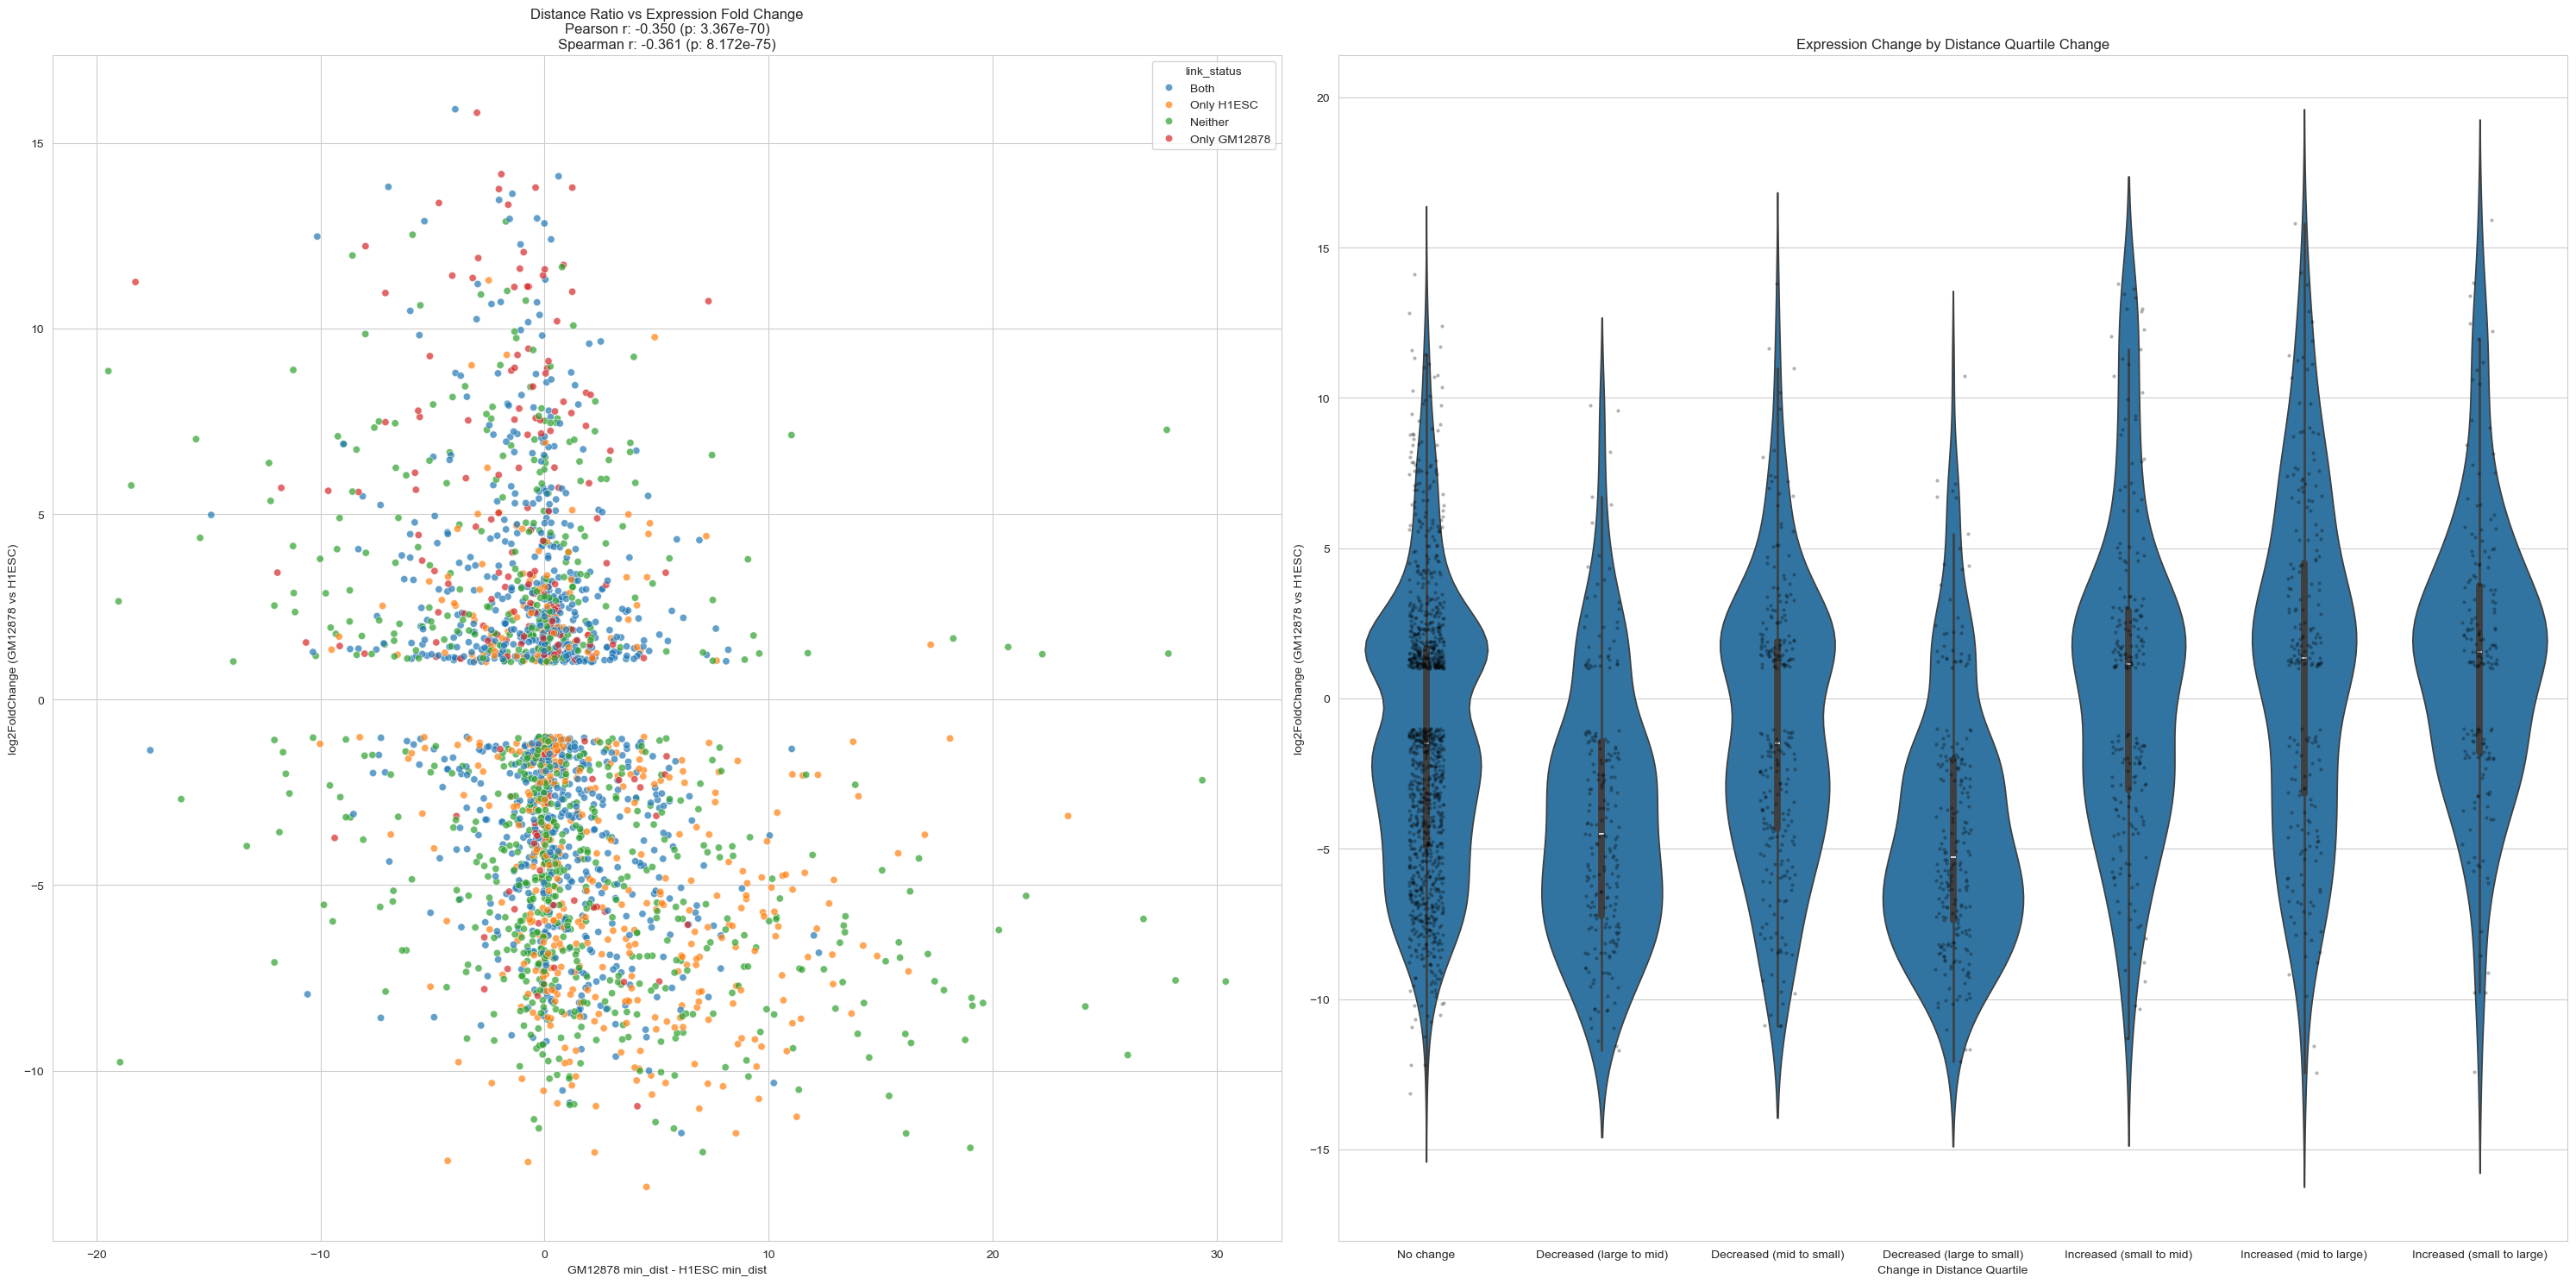

In [16]:
fig, corr_data = plot_distance_vs_expression_correlation(
    gm12878_gene_to_closest_avg_enhancer_all,
    h1esc_gene_to_closest_avg_enhancer_all,
    gm12878_active_genes,
    h1esc_active_genes,
    gm12878_vs_h1esc_results_df,
    "GM12878",
    "H1ESC",
    figsize=(30, 15),
    # filter_by_active_genes=True
)
# plt.show()